In [1]:
# Packages

# To make data frames
import pandas as pd

# To make plots
import matplotlib.pyplot as plt
import seaborn as sns

# Date arithmetic
from datetime import datetime

# For the algorithm
from statsmodels.tsa.holtwinters import Holt

# For cross-validation
from sklearn.model_selection import TimeSeriesSplit

# For making arrays
import numpy as np

In [2]:
# Load the data

old_cleaned_df = pd.read_csv("df_cleaned.csv") # when updating
raw_data = pd.read_csv("..\\TableauProjects\\PollingAverages\\president_polls.csv")

# Parse the dates (need to do it this way so they are actually dates)

old_cleaned_df['end_date'] = pd.to_datetime(old_cleaned_df['end_date'], format='mixed').dt.date
raw_data['end_date'] = pd.to_datetime(raw_data['end_date'], format='mixed').dt.date

# Trim the new raw data (if updating)

next_index = old_cleaned_df['drift_pred'].first_valid_index()
new_date = old_cleaned_df['end_date'][next_index]
raw_data = raw_data[raw_data['end_date'] >= new_date] 

# # Define new_date (if not updating, assumes getting updated everyday)

# new_date = raw_data['end_date'][0] + pd.Timedelta(days=1)

C:\Users\leyjf\AppData\Local\Temp\ipykernel_55304\2282371806.py:4: DtypeWarning: Columns (16,17,26) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("..\\TableauProjects\\PollingAverages\\president_polls.csv")


In [3]:
# Remove the new_date and beyond rows from the old data and clear the model and drift_pred columns

old_cleaned_df = old_cleaned_df.drop(old_cleaned_df[old_cleaned_df['end_date'] >= new_date].index)
old_cleaned_df['model'] = pd.Series(np.nan, index=range(len(old_cleaned_df)))
old_cleaned_df['drift_pred'] = pd.Series(np.nan, index=range(len(old_cleaned_df)))

In [4]:
# Extract the Trump and Harris rows with just the likely voters, with just the columns I want
 
df = raw_data.loc[((raw_data['candidate_name'] == 'Donald Trump') | (raw_data['candidate_name'] == 'Kamala Harris')) &
    (raw_data['population'] == 'lv'),            
    ['pollscore', 'state', 'candidate_name', 'end_date', 'pct']].drop_duplicates()

# # Only data from after Biden drops out (when not updating)

# biden_out = datetime(2024, 7, 21).date()
# df = df[df['end_date'] >= biden_out]

# Restrict to national and swing state polls

swing_states = ["Arizona", "Georgia", "Michigan", "Nevada", "North Carolina", "Pennsylvania", "Wisconsin"]
df = df.loc[df['state'].isin(swing_states) | df['state'].isnull()]

# Only use polls with negative pollscore

df = df.loc[df['pollscore'] < 0]

In [5]:
# Use groupby to get daily averages (unweighted so far)

daily_average = df.groupby(['end_date', 'candidate_name'])['pct'].mean().reset_index(name='daily_average')
df = pd.merge(df, daily_average)
# df

In [6]:
# Create a smaller df for the model and merge the old data with the new data
 
# What we need

df_cleaned = df[['candidate_name', 'end_date', 'daily_average']].drop_duplicates()
 
# Merge the old data with the new data

df_cleaned = pd.concat([old_cleaned_df, df_cleaned], join='outer', ignore_index=True)

# Sort 

df_cleaned.sort_values(['candidate_name', 'end_date'], ascending=[True, True], inplace=True, ignore_index=True)
# df_cleaned


In [7]:
# The candidates

trump = df_cleaned[(df_cleaned['candidate_name'] == 'Donald Trump') & (df_cleaned['end_date'] < pd.Timestamp.today().date())]
harris = df_cleaned[(df_cleaned['candidate_name'] == 'Kamala Harris') & (df_cleaned['end_date'] < pd.Timestamp.today().date())]

In [8]:
# Create splits for hyperparameter tuning

## First we make a split object

## n_splits is the number of splits, here we use 5
## test_size limits the size of the holdout set, here we'll imagine 
## we are using a horizon of 14 (test_size=14)
no_splits = 5
kfold = TimeSeriesSplit(n_splits = no_splits,
                           test_size = 7)

In [9]:
# Get the dates

election_day = pd.to_datetime('2024-11-05')
days_till_then = pd.Series(pd.date_range(start=pd.Timestamp.today().date(), end=election_day)).dt.date

x = pd.concat([df_cleaned['end_date'].drop_duplicates(), days_till_then], ignore_index=True)

# Split the dates

no_test_days = 0 # may want more than 0 for verifying the model is appropriate
x_train = x[:-(len(days_till_then)+no_test_days)]
x_test = x[-(len(days_till_then)+no_test_days):]

In [10]:
# Grid search for choosing the best values for the hyperparameters

# This function takes 3 numpy arrays as inputs.
# It returns the 
# mean absolute error of the forecast on the test set 
# relative to the
# mean absolute error of the naive forecast on the training set over an equivalent horizon.
# 
# If MASE > 1 then your forecast performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then your forecast performs better out of sample than naive forecast does in sample.

def mase(y_train, y_test, y_preds):
    n = len(y_train) 
    #print("n =", n) # for debugging
    m = len(y_test) 
    #print("m =", m) # for debugging
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
        #print("denom =", denom) # for debugging
    denom = denom / (n-m)
    #print("Now denom =", denom) # for debugging
    num = np.abs(y_test - y_preds).mean()
    #print("num =", num) # for debugging
    return num/denom

grid_numbers = np.arange(0, 0.5, .01) # higher numbers were tested and proved to be worse
exp_mase_trump = np.zeros((no_splits, len(grid_numbers), len(grid_numbers)))
exp_mase_harris = np.zeros((no_splits, len(grid_numbers), len(grid_numbers)))

i = 0
for train_index, test_index in kfold.split(x_train):
    #print("train_index is ", train_index) # for debugging
    #print("test_index is ", test_index) # for debugging
    # Use [:-no_test_days] when more than 0
    trump_tt = trump.iloc[train_index] 
    trump_ho = trump.iloc[test_index] 
    harris_tt = harris.iloc[train_index] 
    harris_ho = harris.iloc[test_index] 
    
    j = 0
    for alpha in grid_numbers:
        #print("alpha =", alpha) # for debugging
        k = 0
        for beta in grid_numbers:
            #print("beta =", beta, "(alpha =", alpha, ")") # for debugging
            # Use [:-no_test_days] when more than 0
            exp_smooth_trump = Holt(trump.daily_average.values).fit(smoothing_level=alpha, 
                                                          smoothing_trend=beta,
                                                          optimized=False)
            exp_smooth_harris = Holt(harris.daily_average.values).fit(smoothing_level=alpha, 
                                                          smoothing_trend=beta,
                                                          optimized=False)

            exp_mase_trump[i,j,k] = mase(trump_tt.daily_average.values, trump_ho.daily_average.values, 
                                         exp_smooth_trump.forecast(len(trump_ho)))
            #print("Trump avg cv rmse is", exp_mase_trump[i,j,k]) # for debugging
            exp_mase_harris[i,j,k] = mase(harris_tt.daily_average.values, harris_ho.daily_average.values, 
                                          exp_smooth_harris.forecast(len(harris_ho)))
            #print("Harris avg cv rmse is", exp_mase_harris[i,j,k]) # for debugging
            print("i j k is", i, j, k) # for debugging
            #print("and test_index is", test_index) # for debugging
            k = k + 1
        j = j + 1
    i = i + 1

i j k is 0 0 0
i j k is 0 0 1
i j k is 0 0 2
i j k is 0 0 3
i j k is 0 0 4
i j k is 0 0 5
i j k is 0 0 6
i j k is 0 0 7
i j k is 0 0 8
i j k is 0 0 9
i j k is 0 0 10
i j k is 0 0 11
i j k is 0 0 12
i j k is 0 0 13
i j k is 0 0 14
i j k is 0 0 15
i j k is 0 0 16
i j k is 0 0 17
i j k is 0 0 18
i j k is 0 0 19
i j k is 0 0 20
i j k is 0 0 21
i j k is 0 0 22
i j k is 0 0 23
i j k is 0 0 24
i j k is 0 0 25
i j k is 0 0 26
i j k is 0 0 27
i j k is 0 0 28
i j k is 0 0 29
i j k is 0 0 30
i j k is 0 0 31
i j k is 0 0 32
i j k is 0 0 33
i j k is 0 0 34
i j k is 0 0 35
i j k is 0 0 36
i j k is 0 0 37
i j k is 0 0 38
i j k is 0 0 39
i j k is 0 0 40
i j k is 0 0 41
i j k is 0 0 42
i j k is 0 0 43
i j k is 0 0 44
i j k is 0 0 45
i j k is 0 0 46
i j k is 0 0 47
i j k is 0 0 48
i j k is 0 0 49
i j k is 0 1 0
i j k is 0 1 1
i j k is 0 1 2
i j k is 0 1 3
i j k is 0 1 4
i j k is 0 1 5
i j k is 0 1 6
i j k is 0 1 7
i j k is 0 1 8
i j k is 0 1 9
i j k is 0 1 10
i j k is 0 1 11
i j k is 0 1 12
i j k is 0 1

In [11]:
## This gives us the indices of the smallest
## avg cv mase
exp_ind_trump = np.unravel_index(np.argmin(np.mean(exp_mase_trump, axis=0), axis=None), 
                           np.mean(exp_mase_trump, axis=0).shape)
exp_ind_harris = np.unravel_index(np.argmin(np.mean(exp_mase_harris, axis=0), axis=None), 
                           np.mean(exp_mase_harris, axis=0).shape)
alpha_trump = grid_numbers[exp_ind_trump[0]]
beta_trump = grid_numbers[exp_ind_trump[1]]
alpha_harris = grid_numbers[exp_ind_harris[0]]
beta_harris = grid_numbers[exp_ind_harris[1]]

print("The alpha and beta values that give a double exponential",
         "smoothing model for Trump with lowest avg cv mase are: ",
         "alpha =", alpha_trump,
         "and beta =", beta_trump)

print("The Trump model had an avg cv mase of: ",
         np.round(np.mean(exp_mase_trump, axis=0)[exp_ind_trump],3))  

if np.round(np.mean(exp_mase_trump, axis=0)[exp_ind_trump],3) < 1:
    print("This model performed better than the naïve forecast baseline (where we simply predict the last known value).")
else:
    print("This model did no better than the naïve forecast baseline.")    

print("The alpha and beta values that give a double exponential",
         "smoothing model for Harris with lowest avg cv mase are: ",
         "alpha =", alpha_harris,
         "and beta =", beta_harris)

print("The Harris model had an avg cv mase of: ",
        np.round(np.mean(exp_mase_harris, axis=0)[exp_ind_harris],3)) 

if np.round(np.mean(exp_mase_harris, axis=0)[exp_ind_harris],3) < 1:
    print("This model performed better than the naïve forecast baseline (where we simply predict the last known value).")
else:
    print("This model did no better than the naïve forecast baseline.") 

# Use [:-no_test_days] when more than 0
final_trump_mod = Holt(trump.daily_average.values).fit(smoothing_level=alpha_trump, 
                                                          smoothing_trend=beta_trump,
                                                          optimized=False)
final_harris_mod = Holt(harris.daily_average.values).fit(smoothing_level=alpha_harris, 
                                                          smoothing_trend=beta_harris,
                                                          optimized=False)

The alpha and beta values that give a double exponential smoothing model for Trump with lowest avg cv mase are:  alpha = 0.06 and beta = 0.33
The Trump model had an avg cv mase of:  0.743
This model performed better than the naïve forecast baseline (where we simply predict the last known value).
The alpha and beta values that give a double exponential smoothing model for Harris with lowest avg cv mase are:  alpha = 0.05 and beta = 0.28
The Harris model had an avg cv mase of:  0.475
This model performed better than the naïve forecast baseline (where we simply predict the last known value).


In [12]:
# Random walk with drift baseline

# Use [-no_test_days] and [:-no_test_days] when more than 0
beta_hat_trump = (trump.daily_average.values[-1] - trump.daily_average.values[0])/len(trump)
drift_pred_trump = (trump.daily_average.values[-1] 
                    + beta_hat_trump*np.arange(1, no_test_days + len(days_till_then) + 1))
beta_hat_harris = (harris.daily_average.values[-1] - harris.daily_average.values[0])/len(harris)
drift_pred_harris = (harris.daily_average.values[-1] 
                     + beta_hat_harris*np.arange(1, no_test_days + len(days_till_then) + 1))

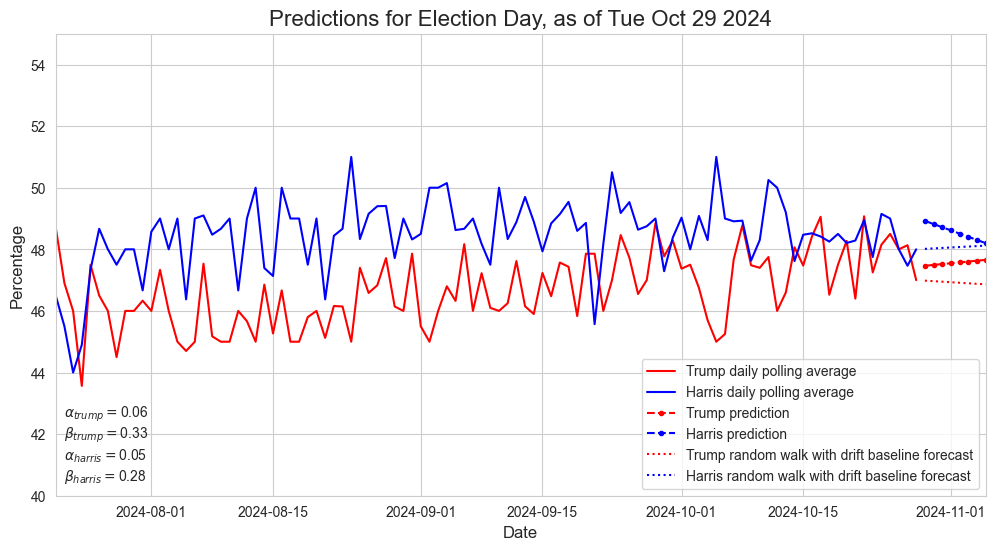

In [13]:
# Plot the data 

null_averages = pd.Series(np.nan, index=range(len(days_till_then)))

## Here's our data
y_trump_obs = pd.concat([trump['daily_average'], null_averages])
y_harris_obs = pd.concat([harris['daily_average'], null_averages])
y_trump_mod = final_trump_mod.fittedvalues 
y_harris_mod = final_harris_mod.fittedvalues 

## Run this code
sns.set_style("whitegrid")

## plt.figure() will make the figure object
## figsize can control how large it is (width,height)
## here we make a 6 x 4 window
plt.figure(figsize=(12, 6))

## The third argument to plot(), 'mp' here
## tells matplotlib to make the points magenta
## and to use pentagrams, the absence of a line character
## means there will be no line connecting these points
## we can also add a label, and insert a legend later
plt.plot(x, y_trump_obs, 'r', label="Trump daily polling average")
plt.plot(x, y_harris_obs, 'b', label="Harris daily polling average")
#plt.plot(x_train, y_trump_mod, 'r--', label="Trump model average")
#plt.plot(x_train, y_harris_mod, 'b--', label="Harris model average")

## We can get the forecast with .forecast(h)
plt.plot(x_test, 
         final_trump_mod.forecast(no_test_days+len(days_till_then)),
         'r--.',
         label="Trump prediction")
plt.plot(x_test, 
         final_harris_mod.forecast(no_test_days+len(days_till_then)),
         'b--.',
         label="Harris prediction")

# Random walk with drift baseline forecast
plt.plot(x_test,
            drift_pred_trump,
            'r:',
            label="Trump random walk with drift baseline forecast")
plt.plot(x_test,
            drift_pred_harris,
            'b:',
            label="Harris random walk with drift baseline forecast")

## we can add axis labels
## and control their fontsize
## A good rule of thumb is the bigger the better
## You want your plots to be readable
## As a note: matplotlib can use LaTeX commands
## so if you place math text in dollar signs it will
## be in a LaTeX environment
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage", fontsize=12)

## we can set the plot axis limits like so
## This makes the x axis bounded between -20 and 20
plt.xlim(datetime(2024, 7, 21), election_day)

## this makes the y axis bounded between -100 and 100
plt.ylim(40, 55)

## Also a title
## again make it large font
plt.title("Predictions for Election Day, as of "+str(pd.Timestamp.today().strftime('%a %b %d %Y')), fontsize=16)


## plt.legend() adds the legend to the plot
## This will display the labels we had above
plt.legend()

trump_vote = round(final_trump_mod.forecast(no_test_days+len(days_till_then))[-1], 1)
harris_vote = round(final_harris_mod.forecast(no_test_days+len(days_till_then))[-1], 1)
                   
# Annotate the point (2, 4)
plt.annotate(r"$\alpha_{trump}=$"+str(alpha_trump)+"\n"
             +r"$\beta_{trump}=$"+str(beta_trump)+"\n"
             +r"$\alpha_{harris}=$"+str(alpha_harris)+"\n"
             +r"$\beta_{harris}=$"+str(beta_harris), 
             xy=(election_day, trump_vote), 
             xytext=(datetime(2024, 7, 22), 40.5))

# Save plot as a png

plt.savefig('forecast_images/'+str(pd.Timestamp.today().date().strftime('%d%b'))+'.png', bbox_inches='tight')

## Always end your plotting block with plt.show
## in jupyter this makes sure that the plot displays 
## properly
plt.show()

In [14]:
# Save cleaned data, with model, forecast, and baseline, to a file

forecast_data_dates = pd.DataFrame(columns = ['end_date', 'candidate_name'])
forecast_data_dates['end_date'] = pd.concat([x,x], ignore_index=True)
forecast_data_dates['candidate_name'] = pd.concat([trump['candidate_name'], pd.Series("Donald Trump", 
    index=range(len(days_till_then))), harris['candidate_name'], pd.Series("Kamala Harris", 
    index=range(len(days_till_then)))], ignore_index=True)
# forecast_data_dates

In [15]:
# Make the cleaned df (only need to do the first time)

df_cleaned = pd.merge(df_cleaned, forecast_data_dates, on=['candidate_name', 'end_date'], how='outer')
# df_cleaned

In [16]:
# Fill in the model and baseline numbers and save to a file

df_cleaned['model'] = pd.concat([pd.Series(y_trump_mod), pd.Series(final_trump_mod.forecast(no_test_days+len(days_till_then))), 
        pd.Series(y_harris_mod), pd.Series(final_harris_mod.forecast(no_test_days+len(days_till_then)))], ignore_index=True)
df_cleaned['drift_pred'] = pd.concat([pd.Series(np.nan, index=range(len(x)-no_test_days-len(days_till_then))),
        pd.Series(drift_pred_trump), pd.Series(np.nan, index=range(len(x)-no_test_days-len(days_till_then))),
        pd.Series(drift_pred_harris)], ignore_index=True)        
df_cleaned.to_csv("df_cleaned.csv", index=False)